In [1]:
# !pip install wandb --upgrade --user
# !pip install monai tensorboard==1.15 --user

# About GPU setting
!nvidia-smi
gpus= "0,1"

import os
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]= gpus;

import torch
gpu_count = torch.cuda.device_count()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('cuda available',torch.cuda.is_available())
print('gpu_count',gpu_count)
print('torch version',torch.__version__)

# Ignore warning
import warnings
warnings.filterwarnings(action='ignore')

# set Logger
import wandb
wandb.login()

Sun Dec 20 14:35:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:02:00.0 Off |                  N/A |
| 41%   41C    P8    14W / 280W |      0MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:03:00.0 Off |                  N/A |
| 41%   

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: keewonshin (use `wandb login --relogin` to force relogin)


True

In [2]:
# import shutil
# img_list = glob.glob('../Brain_Normal_trainset/label/*.nii.gz')
# for idx in range(len(img_list)):
#     src = img_list[idx]
#     dst = '../Brain_Normal_trainset/label/'+img_list[idx].split('/')[-1].split('.')[0]+'_normal.nii.gz'
# #     print(src)
#     shutil.move(src,dst)

# Step 1️⃣. Define the Sweep

### 📃 Sweep mode

In [3]:
sweep_config = {'method': 'random'} # 'grid'
metric = {'name': 'val_loss', 'goal': 'minimize' }

sweep_config['metric'] = metric

### 📃 Name the hyper`parameters`

In [4]:
import math

path_data = '../AMC/'
path_statedict = 'model:segresnet_optimizer:adam_transform:0_fold:0best.pth'
path_statedict = '0UNetbest.pth'

parameters_dict = {
    'epochs': {'values': [100]},
#     'learning_rate': {'distribution': 'uniform','min': 1e-5, 'max': 1e-2},
#     'batch_size': {'distribution': 'q_log_uniform', 'q': 1, 'min': math.log(2),'max': math.log(4)},
    'learning_rate': {'values': [1e-3]},
    'batch_size': {'values': [4*gpu_count]},
    'optimizer': {'values': ['adam']},
    'lossfn': { 'values': ['DiceCE']}, #'CrossEntropy','DiceFocal'
    'model': {'values':['unet']}, #'segresnet' 'unet','ahnet','hiresnet'
    'temperature' : {'values': [0.2]},
    'transform' : {'values': [0]},
    'fold' : {'values': [0]}, # [0,1,2,3,4]    
    'in_channels' : {'values': [1]}, 
    'out_channels' : {'values': [2]},
    }

sweep_config['parameters'] = parameters_dict

# Step 2️⃣. Initialize the Sweep

In [5]:
sweep_id = wandb.sweep(sweep_config, project="BrainHemo3D")

Create sweep with ID: ezbzwpih
Sweep URL: https://wandb.ai/keewonshin/BrainHemo3D/sweeps/ezbzwpih


# Step 3️⃣. Run the Sweep agent

### 💻 Define Your Training Procedure

Before we can actually execute the sweep,
we need to define the training procedure that uses those values.

In the functions below, we define a simple fully-connected neural network in PyTorch, and add the following `wandb` tools to log model metrics, visualize performance and output and track our experiments:
* [**`wandb.init()`**](https://docs.wandb.com/library/init) – Initialize a new W&B Run. Each Run is a single execution of the training function.
* [**`wandb.config`**](https://docs.wandb.com/library/config) – Save all your hyperparameters in a configuration object so they can be logged. Read more about how to use `wandb.config` [here](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/wandb-config/Configs_in_W%26B.ipynb).
* [**`wandb.log()`**](https://docs.wandb.com/library/log) – log model behavior to W&B. Here, we just log the performance; see [this Colab](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/wandb-log/Log_(Almost)_Anything_with_W%26B_Media.ipynb) for all the other rich media that can be logged with `wandb.log`.

For more details on instrumenting W&B with PyTorch, see [this Colab](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Simple_PyTorch_Integration.ipynb).

In [6]:
import glob
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms

import tqdm
from tqdm import trange
from sklearn.metrics import *
import monai
from monai.config import print_config
from monai.data import CacheDataset, list_data_collate
from monai.inferers import sliding_window_inference
from monai.losses import *
from monai.metrics import compute_meandice
from monai.networks.layers import Norm
from monai.networks.nets import *
from monai.transforms import *
from monai.utils import set_determinism

from monai.config import print_config
from monai.data import Dataset, CacheDataset, DataLoader, create_test_image_3d
from monai.engines import EnsembleEvaluator, SupervisedEvaluator, SupervisedTrainer
from monai.handlers import MeanDice, StatsHandler, ValidationHandler
from monai.inferers import SimpleInferer, SlidingWindowInferer

set_determinism(seed=0)
print_config()

MONAI version: 0.3.0+109.g8f80ac5
Numpy version: 1.19.4
Pytorch version: 1.7.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 8f80ac521b00d75c247a21e6a2aae87408ef4790

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.2.0
scikit-image version: 0.17.2
Pillow version: 8.0.1
Tensorboard version: 2.3.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.8.1
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.51.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.7.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [7]:
# # patch_size = (64,64,16)
# patch_size = (256,256,16)

# train_transforms = Compose(
#     [
#         LoadNiftid(keys=["image", "label"]),
#         AddChanneld(keys=["image", "label"]),        
        
#         #spacing
# #         Spacingd(keys=["image", "label"], pixdim=(.67, .67), mode=("bilinear", "nearest")),
# #         Spacingd(keys=["image", "label"], pixdim=(.67, .67, 3.0), mode=("nearest", "nearest")),

#         # windowing
#         ScaleIntensityRanged(keys=["image"], a_min=40-140/2, a_max=40+140/2, b_min=0.0, b_max=1.0, clip=True),
# #         ScaleIntensityRanged(keys=["label"], a_min=0, a_max=2, b_min=0, b_max=2, clip=True),
        
#         # intensity & smoothing & sharpen
#         RandGaussianNoised(keys=["image"],mean=0.0, std=0.05,prob=0.3),
#         RandAdjustContrastd(keys=["image"],gamma=(0.5, 4.5), prob=0.3),
#         RandShiftIntensityd(keys=["image"],offsets= (-0.1, 0.1), prob=0.3),
#         RandScaleIntensityd(keys=["image"],factors= (0, 0.1), prob=0.3),
#         RandGaussianSmoothd(keys=["image"],sigma_x=(0.25, 1.0), sigma_y=(0.25, 1.0), sigma_z=(0.25, 1.0), prob=0.3),
#         RandHistogramShiftd(keys=["image"],num_control_points=(10,20), prob=0.3),
# #         RandGaussianSharpend(keys=["image"],sigma1_x=(0.1, 1.0), sigma1_y=(0.1, 1.0), sigma1_z=(0.1, 1.0), sigma2_x=0.5, sigma2_y=0.5, sigma2_z=0.5, alpha=(10.0, 30.0), prob=.5),
        
#         # spatial
#         RandFlipd(keys=["image","label"], spatial_axis=[0,1], prob=0.3),        
#         RandRotate90d(keys=["image", "label"], spatial_axes=[0,1],prob=0.3),
#         RandCropByPosNegLabeld(
#             keys=["image", "label"],
#             label_key="label",
#             spatial_size=patch_size,
#             pos=1,
#             neg=1.5,
#             num_samples=4,
#         ),
# #         Rand3DElasticd(
# #                 keys=["image", "label"],
# #                 mode=("bilinear", "nearest"),
# #                 prob=0.3,
# #                 sigma_range=(7, 9),
# #                 magnitude_range=(100, 150),
# #                 spatial_size=patch_size,
# #                 rotate_range=(0, 0, np.pi / 2),
# #                 shear_range=(0.1, 0.1, 0),
# #                 scale_range=(0.1, 0.1, 0),
# #                 padding_mode="border",
# #                 device=device,
# #                 ),
        
#         CastToTyped(keys=["image", "label"], dtype=(np.float32, np.uint8)),
#         ToTensord(keys=["image", "label"]),
#     ]
# )
# val_transforms = Compose(
#     [
#         LoadNiftid(keys=["image", "label"]),
#         AddChanneld(keys=["image", "label"]),            
#         ScaleIntensityRanged(keys=["image"], a_min=40-140/2, a_max=40+140/2, b_min=0.0, b_max=1.0, clip=True),
# #         ScaleIntensityRanged(keys=["image"], a_min=30-500/2, a_max=30+500/2, b_min=0.0, b_max=1.0, clip=True),
# #         ScaleIntensityRanged(keys=["label"], a_min=0, a_max=2, b_min=0, b_max=2, clip=True),
        
#         CastToTyped(keys=["image", "label"], dtype=(np.float32, np.uint8)),
#         ToTensord(keys=["image", "label"]),
#     ]
# )

In [8]:
# val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)
# test_ds = Dataset(data=test_files, transform=val_transforms)
# test_loader = DataLoader(test_ds, batch_size=1, num_workers=2)
# test1_ds = Dataset(data=test1_files, transform=val_transforms)
# test1_loader = DataLoader(test1_ds, batch_size=1, num_workers=2)

In [9]:
def train(config=None):
    # Initialize a new wandb run

    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        config = wandb.config
        experiment = "model:{}_optimizer:{}_transform:{}_fold:{}".format(config.model, config.optimizer, config.transform, config.fold)
        print('Experiment:',experiment)

        train_loader, val_loader = build_dataset(path_data, config.fold, config.batch_size)
        model = build_model(config.model,path_statedict,config.in_channels,config.out_channels)
        optimizer = build_optimizer(model, config.optimizer, config.learning_rate)
        lossfn = build_loss(config.lossfn)
        
        val_losses = list()
        for epoch in range(config.epochs):
            
            train_loss, train_metric = train_epoch(model, train_loader, optimizer, lossfn)
            val_loss, val_metric = val_epoch(model, val_loader, lossfn)
            
            val_losses.append(val_loss)    
            if epoch >= 3 and val_loss == np.min(val_losses):
                if torch.cuda.device_count() > 1:
                    torch.save(model.module.state_dict(),experiment+'best.pth')
                else:
                    torch.save(model.state_dict(), str(fold)+modelname+'best.pth')
                print('saved new best val_loss of the model')                
            elif epoch >= 3 and val_losses != np.min(val_losses):
                config.learning_rate = config.learning_rate * .95
                optimizer = build_optimizer(model, config.optimizer, config.learning_rate)

            wandb.log({
                "train_loss": train_loss,
                "train_metric": train_metric,
                "val_loss": val_loss,
                "val_metric": val_metric,
                "epoch": epoch,
            })           

In [10]:
from losses import *
patch_size = (256,256,16)
    
train_transforms = Compose(
    [
        LoadNiftid(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),        

        #spacing
#         Spacingd(keys=["image", "label"], pixdim=(.67, .67), mode=("bilinear", "nearest")),
#         Spacingd(keys=["image", "label"], pixdim=(.67, .67, 3.0), mode=("nearest", "nearest")),

        # windowing
        ScaleIntensityRanged(keys=["image"], a_min=40-140/2, a_max=40+140/2, b_min=0.0, b_max=1.0, clip=True),
#         ScaleIntensityRanged(keys=["label"], a_min=0, a_max=2, b_min=0, b_max=2, clip=True),

        # intensity & smoothing & sharpen
        RandGaussianNoised(keys=["image"],mean=0.0, std=0.05,prob=0.3),
        RandAdjustContrastd(keys=["image"],gamma=(0.5, 4.5), prob=0.3),
        RandShiftIntensityd(keys=["image"],offsets= (-0.1, 0.1), prob=0.3),
        RandScaleIntensityd(keys=["image"],factors= (0, 0.1), prob=0.3),
        RandGaussianSmoothd(keys=["image"],sigma_x=(0.25, 1.0), sigma_y=(0.25, 1.0), sigma_z=(0.25, 1.0), prob=0.3),
        RandHistogramShiftd(keys=["image"],num_control_points=(10,20), prob=0.3),
#         RandGaussianSharpend(keys=["image"],sigma1_x=(0.1, 1.0), sigma1_y=(0.1, 1.0), sigma1_z=(0.1, 1.0), sigma2_x=0.5, sigma2_y=0.5, sigma2_z=0.5, alpha=(10.0, 30.0), prob=.5),

        # spatial
        RandFlipd(keys=["image","label"], spatial_axis=[0,1], prob=0.3),        
        RandRotate90d(keys=["image", "label"], spatial_axes=[0,1],prob=0.3),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=patch_size,
            pos=1,
            neg=1.5,
            num_samples=4,
        ),
#         Rand3DElasticd(
#                 keys=["image", "label"],
#                 mode=("bilinear", "nearest"),
#                 prob=0.3,
#                 sigma_range=(7, 9),
#                 magnitude_range=(100, 150),
#                 spatial_size=patch_size,
#                 rotate_range=(0, 0, np.pi / 2),
#                 shear_range=(0.1, 0.1, 0),
#                 scale_range=(0.1, 0.1, 0),
#                 padding_mode="border",
#                 device=device,
#                 ),

        CastToTyped(keys=["image", "label"], dtype=(np.float32, np.uint8)),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadNiftid(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),            
        ScaleIntensityRanged(keys=["image"], a_min=40-140/2, a_max=40+140/2, b_min=0.0, b_max=1.0, clip=True),
#         ScaleIntensityRanged(keys=["image"], a_min=30-500/2, a_max=30+500/2, b_min=0.0, b_max=1.0, clip=True),
#         ScaleIntensityRanged(keys=["label"], a_min=0, a_max=2, b_min=0, b_max=2, clip=True),

        CastToTyped(keys=["image", "label"], dtype=(np.float32, np.uint8)),
        ToTensord(keys=["image", "label"]),
    ]
)
def build_dataset(path_data, fold, batch_size):

    
    x_train = sorted(glob.glob(path_data+'imageTr/*.nii.gz'))
    y_train = sorted(glob.glob(path_data+'labelTr/*.nii.gz'))
    
    folds = 5
    x_train_split = monai.data.partition_dataset(data=x_train,num_partitions=folds,seed=0,shuffle=True)
    y_train_split = monai.data.partition_dataset(data=y_train,num_partitions=folds,seed=0,shuffle=True)

    train_files,val_files = list(), list()
    for idx in range(folds):
        if idx == fold:
            val_files.extend([{"image": img, "label": seg} for img, seg in zip(x_train_split[idx],y_train_split[idx])])
        else:
            train_files.extend([{"image": img, "label": seg} for img, seg in zip(x_train_split[idx],y_train_split[idx])])

#     train_files = train_files[:24]
#     val_files = train_files[:4]
    
    train_ds = Dataset(data=train_files, transform=train_transforms)
    val_ds = Dataset(data=val_files, transform=val_transforms)
    train_loader = DataLoader(train_ds, batch_size=batch_size*gpu_count, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)
    print('train: {}, valid: {}'.format(len(train_ds),len(val_ds)))
    return train_loader, val_loader

def build_optimizer(model, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return optimizer

def build_model(model,path_statedict=None,in_channels=1,out_channels=2):
    if model == "unet":
        model = UNet(dimensions=3, in_channels=1, out_channels=2, channels=(32, 64, 128, 256, 512), strides=(2, 2, 2, 2), num_res_units=3, norm=Norm.INSTANCE)
    elif model == "segresnet":
        model = SegResNet(spatial_dims=3, in_channels=1, out_channels=2, init_filters=8)
    elif model == "ahnet":
        model = AHNet(spatial_dims=3, in_channels=1, out_channels=2, pretrained=True)
    elif model == "hiresnet":
        model = HighResNet(spatial_dims=3, in_channels=1, out_channels=2)
        
    if path_statedict is not None:
        try:
            model_w = torch.load(path_statedict)
            model.load_state_dict(model_w, strict=False)
            print('loading weights is successfully done')
        except:
            print('loading weights is failed')
            
    # do not change here
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)
    model= model.to(device)

    return model

def build_loss(loss = "CrossEntropy"):
    if loss == "CrossEntropy":
        lossfn = CrossEntropyLoss()
    elif loss == "DiceCE":
        lossfn = DiceCELoss()
    elif loss == "DiceFocal":
        lossfn = DiceFocalLoss()
    return lossfn

# class CrossEntropyLoss(nn.Module):
#     def __init__(self):
#         super().__init__()
# #         self.loss = nn.CrossEntropyLoss(weight=torch.tensor([.1,.2,.4,.4]))
#         self.loss = nn.CrossEntropyLoss()

#     def forward(self, y_pred, y_true):
#         # CrossEntropyLoss target needs to have shape (B, D, H, W)
#         # Target from pipeline has shape (B, C, D, H, W)
#         y_true = torch.squeeze(y_true, dim=1).long()
#         return self.loss(y_pred, y_true)

# class DiceCELoss(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.dice = GeneralizedDiceLoss(to_onehot_y=True)
#         self.cross_entropy = CrossEntropyLoss()

#     def forward(self, y_pred, y_true):
#         dice = self.dice(y_pred, y_true)
#         cross_entropy = self.cross_entropy(y_pred, y_true)
#         return dice + cross_entropy
    
# class DiceFocalLoss(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.dice = GeneralizedDiceLoss(to_onehot_y=True)
#         self.focal = FocalLoss(gamma=2)

#     def forward(self, y_pred, y_true):
#         dice = self.dice(y_pred, y_true)
#         focal = self.focal(y_pred, y_true)
#         return dice + focal

def softmax_T(inputs,T=0.1):
    '''
    input should be torch and B*C*H...
    '''
#     T = config.temperature
    return torch.softmax(inputs/T,1)

def train_epoch(model, loader, optimizer, lossfn):

    model.train()
    epoch_loss = 0
    epoch_metric = 0

    for batch_data in tqdm.tqdm(loader, desc='train'):
        x, y = batch_data['image'].to(device), batch_data['label'].to(device)
        optimizer.zero_grad()

        # ➡ Forward pass        
        y_hat = softmax_T(model(x))
        loss = lossfn(y_hat, y)
        epoch_loss += loss.item()

        # ⬅ Backward pass + weight update
        loss.backward()
        optimizer.step()
        
        y_hat = torch.argmax(y_hat,1)
        metric = f1_score(y.detach().cpu().numpy().flatten(), y_hat.detach().cpu().numpy().flatten())
        epoch_metric += metric

        wandb.log({"batch_train_loss": loss.item()})
        wandb.log({"batch_train_metric": metric})
        
    return epoch_loss / len(loader), epoch_metric / len(loader)

def val_epoch(model, loader, lossfn):

    model.eval()
    epoch_loss = 0
    epoch_metric = 0

    for batch_data in tqdm.tqdm(loader, desc='valid'):
        x, y = batch_data['image'].to(device), batch_data['label'].to(device)
       
        sw_batch_size = 2
        y_hat = softmax_T(sliding_window_inference(x, patch_size, sw_batch_size, model))

        loss = lossfn(y_hat, y)
        epoch_loss += loss.item()

        y_hat = torch.argmax(y_hat,1)
        metric = f1_score(y.detach().cpu().numpy().flatten(), y_hat.detach().cpu().numpy().flatten())
        epoch_metric += metric

        wandb.log({"batch_val_loss": loss.item()})
        wandb.log({"batch_val_metric": metric})
        
    return epoch_loss / len(loader), epoch_metric / len(loader)

In [ ]:
# train(sweep_config)

# Run Sweeps

In [ ]:
wandb.agent(sweep_id, train, count=1)

# Test

In [11]:
from utils import *
# gif_nii_imageLabelPred(filename,image,label,pred,file_format='gif',fps= 2)
# from IPython.display import Image
# Image(url='example.gif')  

In [20]:
x_test = sorted(glob.glob(path_data+'imageTs/*hemo*.nii.gz'))
y_test = sorted(glob.glob(path_data+'labelTs/*hemo*.nii.gz'))
test_files = [{"image": img, "label": seg} for img, seg in zip(x_test,y_test)]

test_ds = Dataset(data=test_files, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=2)

# model = build_model(model='segresnet',path_statedict='0SegResNetbest.pth',in_channels=1,out_channels=2)
model = build_model(model='unet',path_statedict='0UNetbest.pth',in_channels=1,out_channels=2)

def test(model,loader,vis=True,save_nii=False,save_gif=False):
    model.eval()
    with torch.no_grad():
        for val_data in tqdm.tqdm(loader):
            x = val_data["image"] 
            y = val_data["label"]
            
            fname_image = val_data["image_meta_dict"]['filename_or_obj'][0]
            fname_label = val_data["label_meta_dict"]['filename_or_obj'][0]
            fname_image = 'Output/image_'+fname_image.split('/')[-1]
            fname_label = 'Output/label_'+fname_label.split('/')[-1]
            fname_pred = 'Output/pred_'+fname_image.split('/')[-1]
            
            affine = val_data["image_meta_dict"]['affine'][0]
            original_affine = val_data["image_meta_dict"]['original_affine'][0]
            spatial_shape = val_data["image_meta_dict"]['spatial_shape'][0]

            roi_size = patch_size
            sw_batch_size = 4
            y_hat = sliding_window_inference(x.to(device), roi_size, sw_batch_size, model, 0.5, 'gaussian')
            y_hat = softmax_T(y_hat)
    #         y_hat = torch.argmax(y_hat, dim=1).unsqueeze(1)
            y_hat = y_hat[:,1].unsqueeze(1)
            
            if vis ==True:
                result = vis_nii_imageLabelPred(x.squeeze(),y.squeeze(),y_hat.squeeze().cpu().detach().numpy().round(),file_format='gif',fps= 2)
                for idx in range(len(result)):
                    plt.figure(figsize=(18, 6))
                    plt.imshow(result[idx])
                    plt.axis('off')
                    plt.title('image                                                                                        GT                                                                                        prediction')
                    plt.show()                

            if save_gif==True:
                gif_nii_imageLabelPred(fname_image,x.squeeze(),y.squeeze(),y_hat.squeeze().cpu().detach().numpy().round(),file_format='gif',fps= 2)

            if save_nii==True:
                monai.data.write_nifti(data=x.cpu().detach().numpy().squeeze(),
                                       file_name=fname_image,
                                       resample=True,
                                       affine=affine,
                                       target_affine=original_affine,
                                       output_spatial_shape=spatial_shape)

                monai.data.write_nifti(data=y.cpu().detach().numpy().squeeze(),
                                       file_name=fname_label,
                                       resample=True,
                                       affine=affine,
                                       target_affine=original_affine,
                                       output_spatial_shape=spatial_shape)

                monai.data.write_nifti(data=y_hat.cpu().detach().numpy().squeeze(),
                                       file_name=fname_pred,
                                       resample=True,
                                       affine=affine,
                                       target_affine=original_affine,
                                       output_spatial_shape=spatial_shape)

loading weights is successfully done
Let's use 2 GPUs!


  0%|          | 0/30 [00:00<?, ?it/s]

(32, 512, 1536, 3)


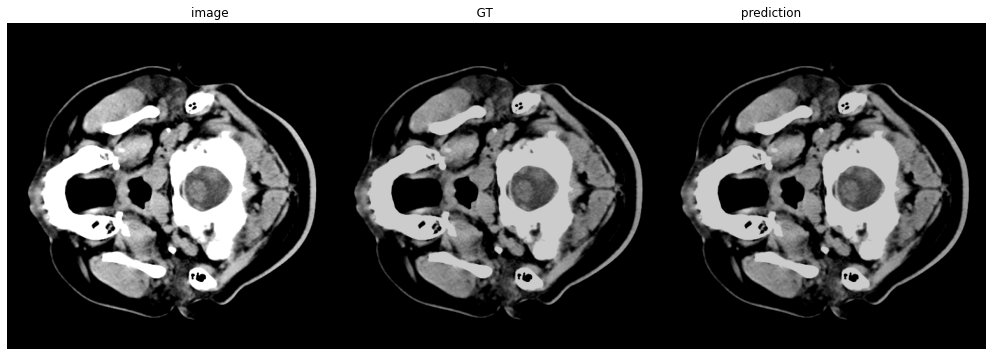

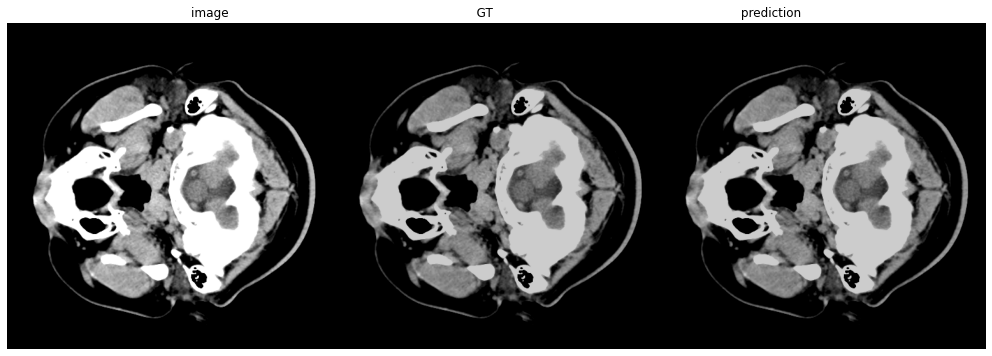

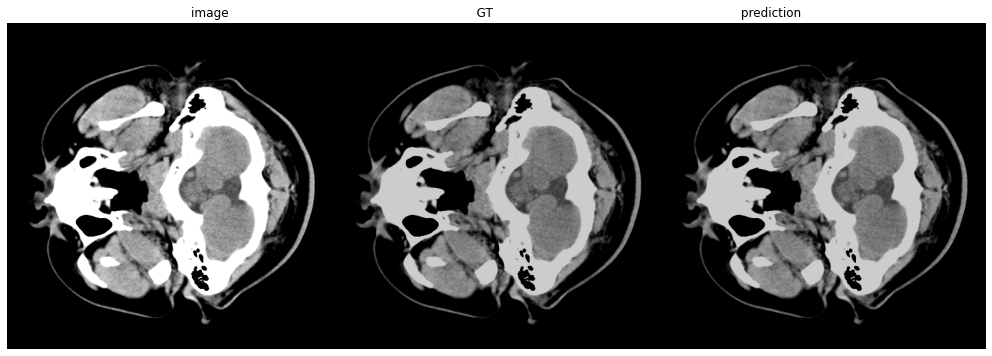

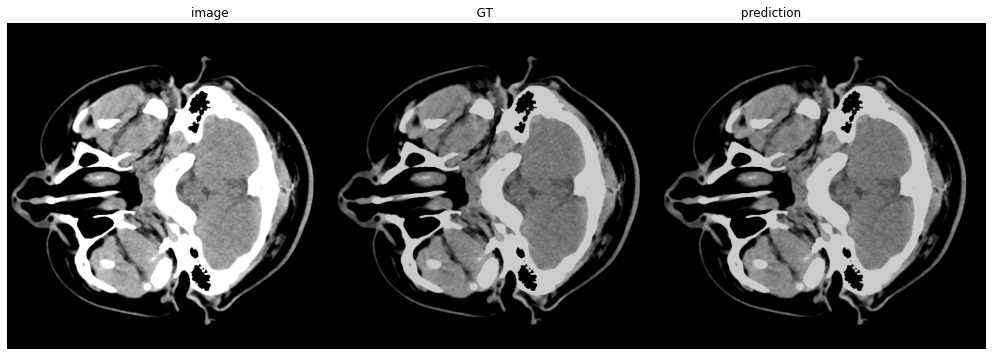

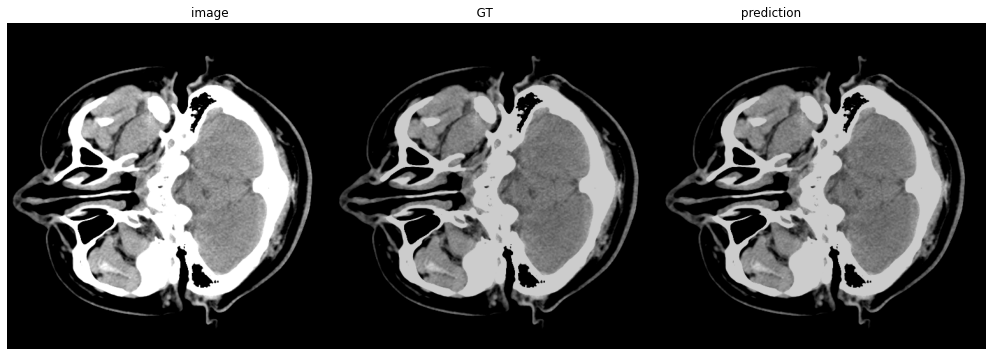

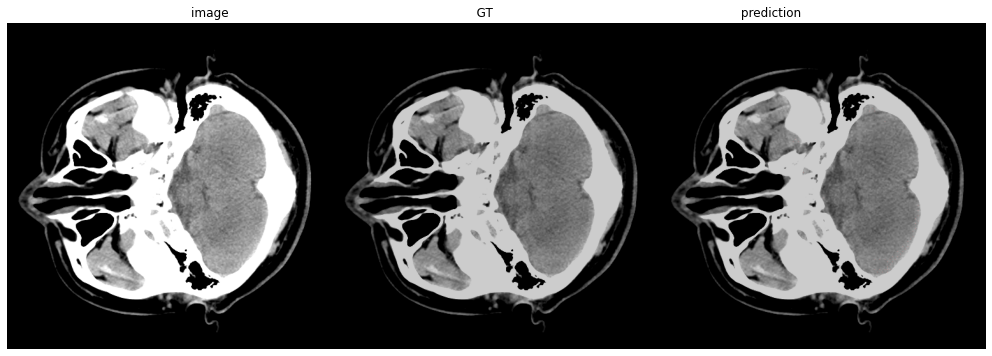

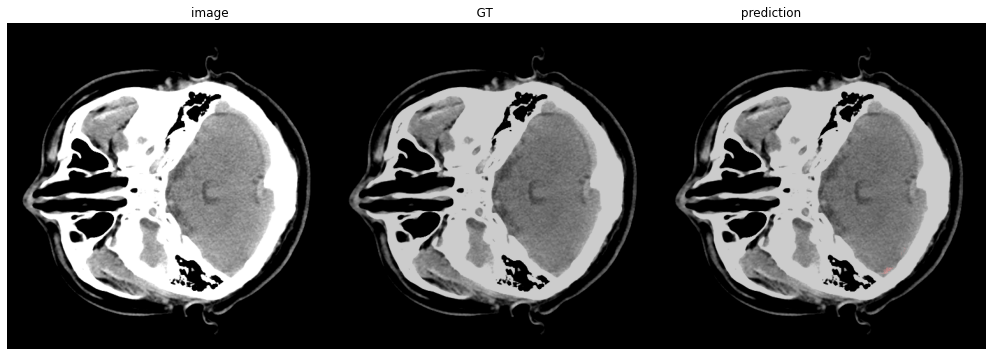

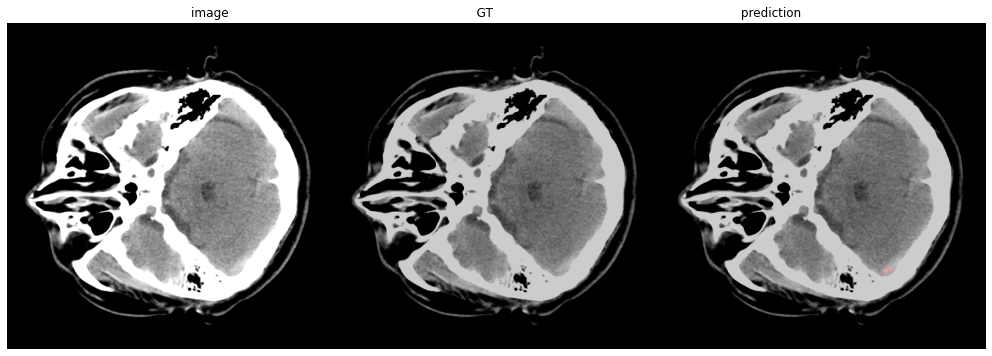

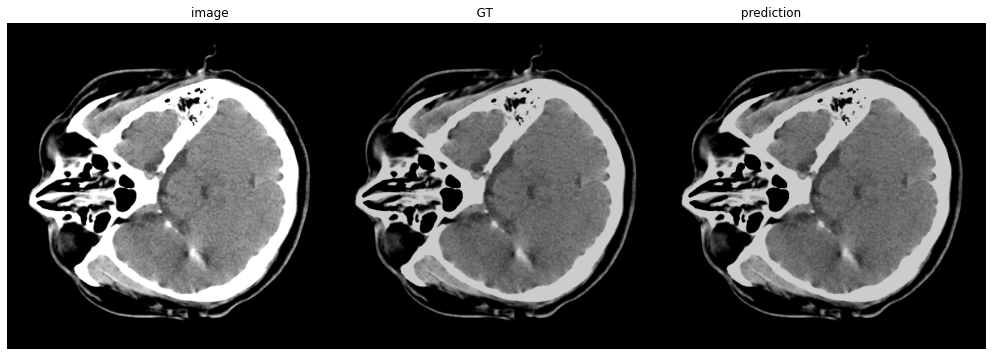

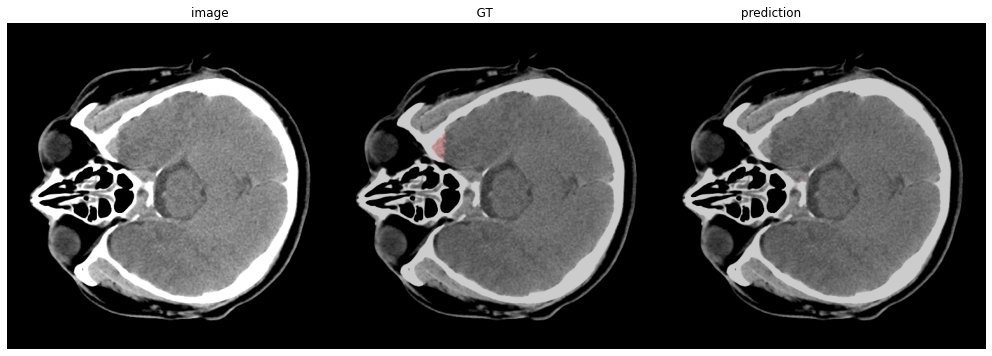

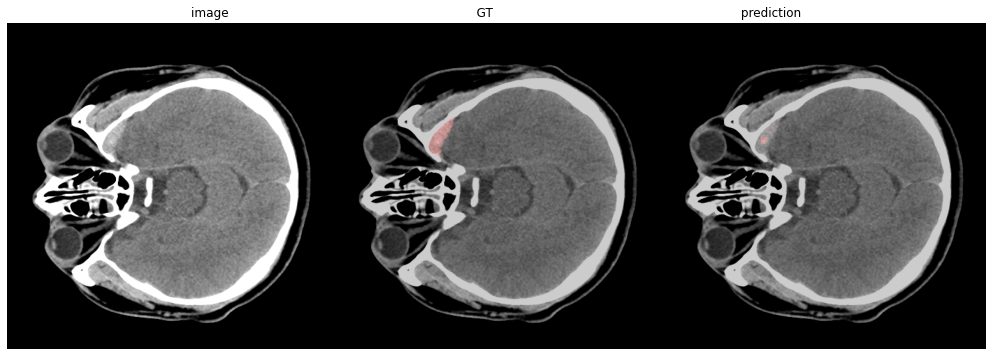

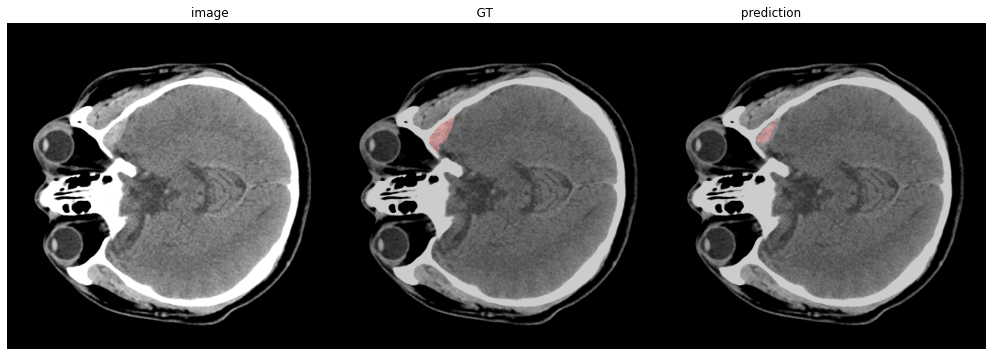

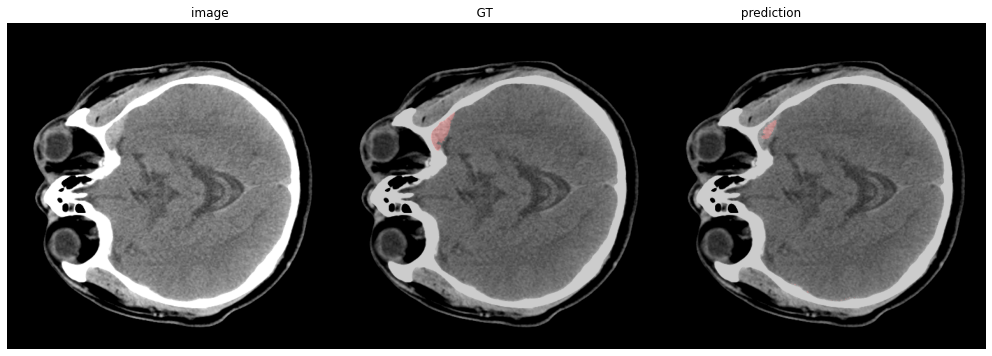

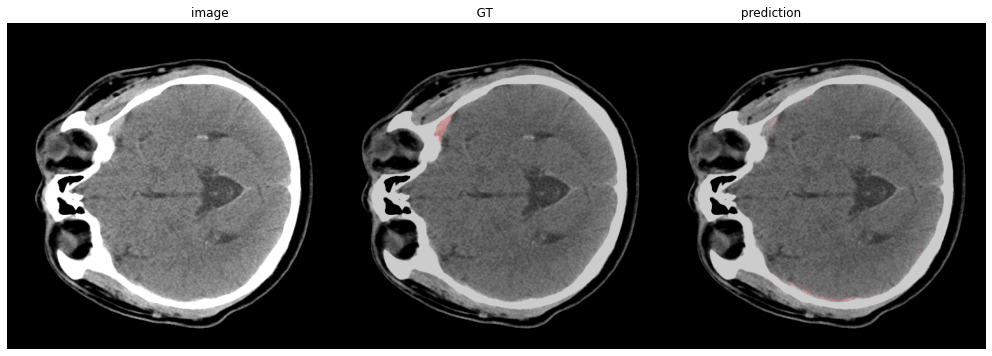

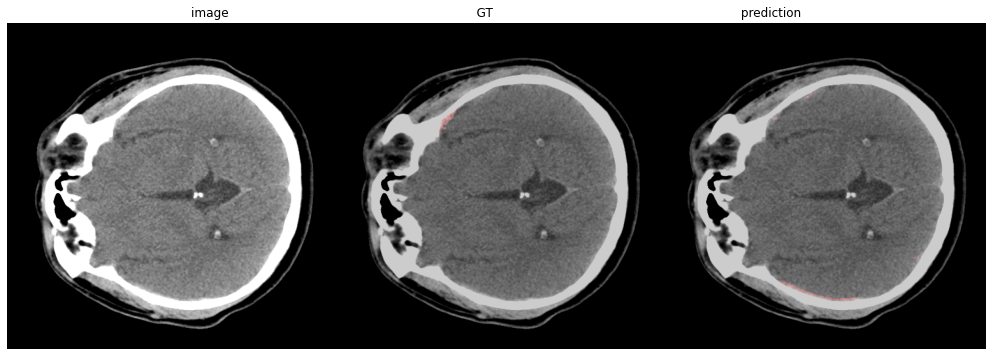

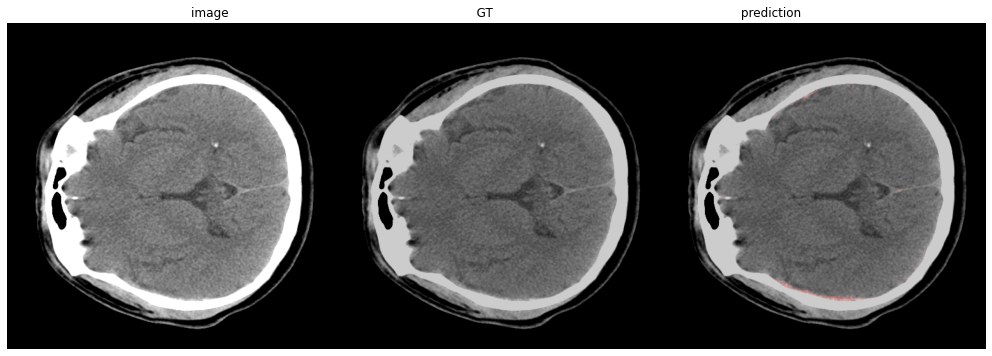

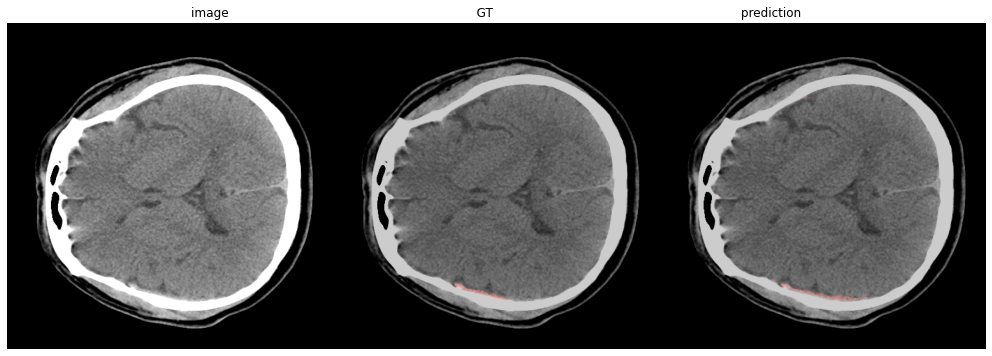

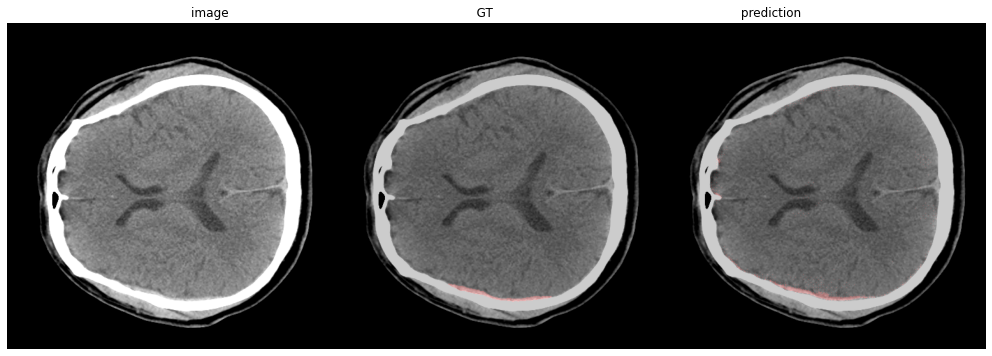

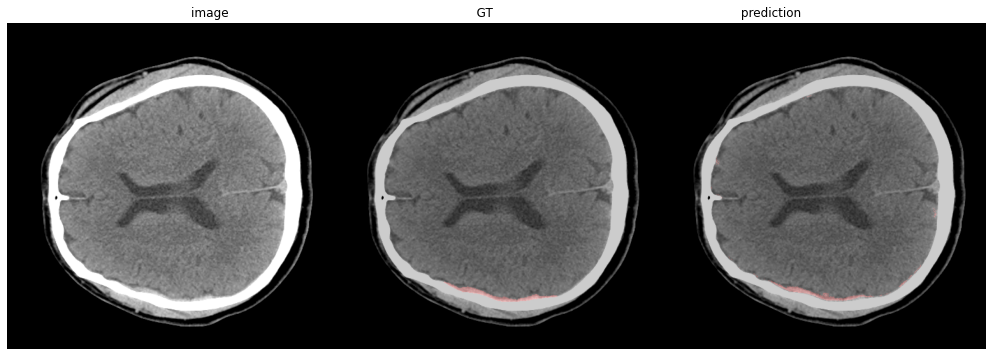

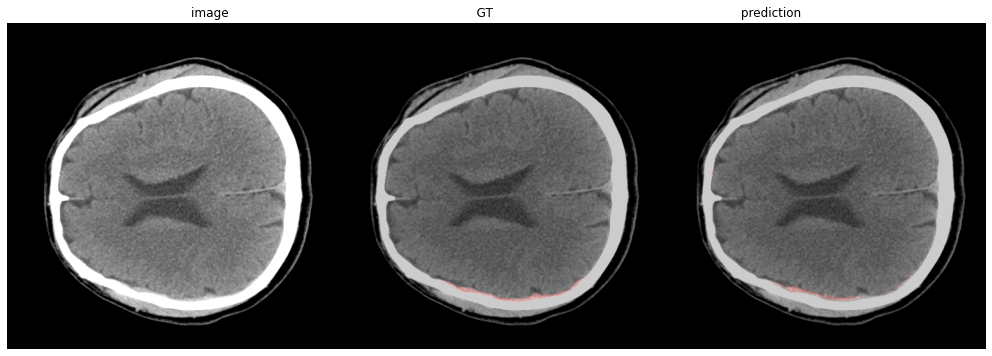

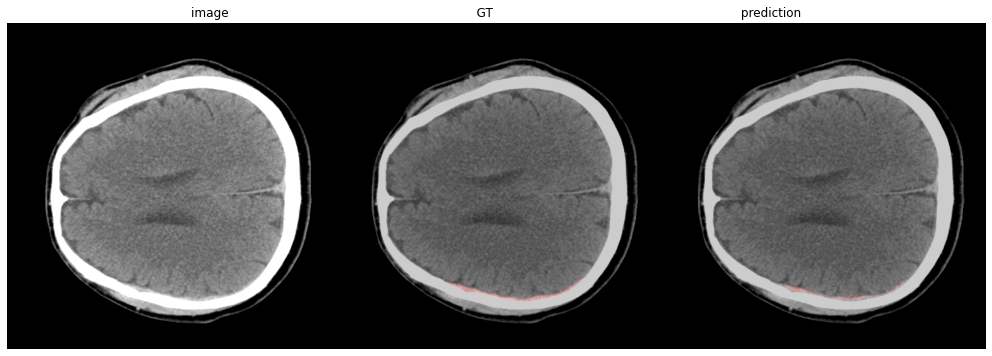

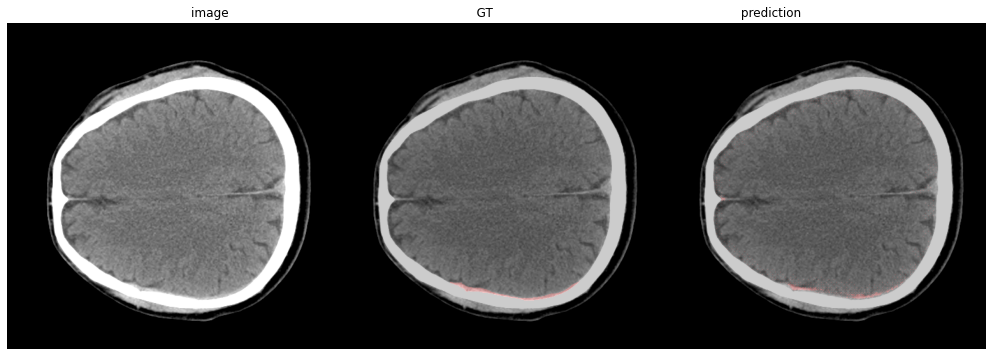

  0%|          | 0/30 [00:24<?, ?it/s]


KeyboardInterrupt: 

In [21]:
test(model,test_loader)